In [1]:
from Bio.Seq import Seq
from Bio import SeqIO
from collections import Counter
from Bio.PDB import PDBParser
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score,classification_report,confusion_matrix
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import json
import time
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import nglview as nv

In [2]:
for record in SeqIO.parse('parkin.fasta','fasta'):
    parkin = record
    parkin_dna = record.seq
print(parkin)

ID: AB009973.1
Name: AB009973.1
Description: AB009973.1 Homo sapiens parkin mRNA for Parkin, complete cds
Number of features: 0
Seq('TCCGGGAGGATTACCCAGGAGACCGCTGGTGGGAGGCGCGGCTGGCGCCGCTGC...AAA', SingleLetterAlphabet())


In [4]:
len(parkin)

2960

In [5]:
mrna_parkin = parkin_dna.transcribe()
mrna_parkin

Seq('UCCGGGAGGAUUACCCAGGAGACCGCUGGUGGGAGGCGCGGCUGGCGCCGCUGC...AAA', RNAAlphabet())

In [6]:
protein_parkin = mrna_parkin.translate()
len(protein_parkin), protein_parkin

C:\Users\kunjk\kunj\lib\site-packages\Bio\Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


(986,
 Seq('SGRITQETAGGRRGWRRCAHGPVPGPQPPPTQ*P**CLSGSTPAMVSQWRSILT...*H*', HasStopCodon(ExtendedIUPACProtein(), '*')))

In [7]:
#finding all amino acids sequence before stop codon
parkin_aa= protein_parkin.split('*')
parkin_aa

[Seq('SGRITQETAGGRRGWRRCAHGPVPGPQPPPTQ', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('P', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('CLSGSTPAMVSQWRSILTPASSSSRRWLLSDRGFRLTSCV', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('FSQGRS', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('GMTGLCRIVTWISRALFTLCRDRGEKVKK', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('MQLEATTPETRREAVSGSPRA', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('LGWTSAAQSSQETLWGWLSFCTLTAGRTHHQLEVQQVDQSTTAFMCIAKAPVKE...RSP', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('PRVHLAGMMF', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('FQTG', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('VVNANPHTALGLVQNFSLNVEHTPPLTRKHQ', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('LCT', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('SQQIVGTSLALRAQTSGAPSWFSSATPAT', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('FA', HasStopCodon(ExtendedIUPACProtein(

In [9]:
parkin_aa_string = [str(i) for i in parkin_aa]
parkin_aa_string

['SGRITQETAGGRRGWRRCAHGPVPGPQPPPTQ',
 'P',
 '',
 'CLSGSTPAMVSQWRSILTPASSSSRRWLLSDRGFRLTSCV',
 'FSQGRS',
 'GMTGLCRIVTWISRALFTLCRDRGEKVKK',
 'MQLEATTPETRREAVSGSPRA',
 'LGWTSAAQSSQETLWGWLSFCTLTAGRTHHQLEVQQVDQSTTAFMCIAKAPVKECSRENSGYSAAPAGRQRSP',
 'PRVHLAGMMF',
 'FQTG',
 'VVNANPHTALGLVQNFSLNVEHTPPLTRKHQ',
 'LCT',
 'SQQIVGTSLALRAQTSGAPSWFSSATPAT',
 'FA',
 'TVSTYTV',
 'QDSMIGSLFTTLNLATPCLVWLAVPTP',
 'LKSSITSGFWEKSSTTGTSSMVQRSVSCRWGACYAPALAVERGCCRSLTRGKSPAKGAMAWAVGLPSAGNVKKRTMKGSAVPYLKPQEQLLRPTESMKEPPSRLVGKQPPKKPSRKPPSPVPAAMYQWKKMEAACT',
 'SVRSPSAGSSGAGTVAASGTASAWGTTGSTCSQGGRAPHRHILGEHTQCLPSFSNSLFKHTHTRARAHTHSSSFFQSPTTAKLQKKLLDPFHYVHEKQQSKITEEAPESLSVCPHKTAEPSATPPTGVLSLRMTQIPEHRFKCNPCICMGHSHLNSRQAESVAGERVLTFNILPFTFSKHHEDAIDKVFLCKMNCSGFSKLDSWL',
 'Q',
 'CSYLNFQKASIPKEPQAIVKNICLSLRIPSI',
 'IALIEIPTMCKSTCHKVRNYES',
 'FEC',
 'MFELQGRNQVNVLSFPFMICNFRKKLFF',
 'KYHQKIYSLILSIHFATWRFC',
 'YIWLHCKFNR',
 'SAYKGNTFRNDFKMIFNLNKSEHY',
 'IRIFKEEPFQNYQNEDTPDSLHQKGLYPFGTPSLSNLQVPGSSAYQGFPRRDLLLGQ',
 'TH',
 'NIP

In [12]:
amino_parkin = pd.DataFrame({'amino_acids':parkin_aa_string})
amino_parkin

,amino_acids
0,SGRITQETAGGRRGWRRCAHGPVPGPQPPPTQ
1,P
2,
3,CLSGSTPAMVSQWRSILTPASSSSRRWLLSDRGFRLTSCV
4,FSQGRS
5,GMTGLCRIVTWISRALFTLCRDRGEKVKK
6,MQLEATTPETRREAVSGSPRA
7,LGWTSAAQSSQETLWGWLSFCTLTAGRTHHQLEVQQVDQSTTAFMC...
8,PRVHLAGMMF
9,FQTG


In [13]:
amino_parkin['count'] = amino_parkin['amino_acids'].str.len()
amino_parkin.head()

,amino_acids,count
0,SGRITQETAGGRRGWRRCAHGPVPGPQPPPTQ,32
1,P,1
2,,0
3,CLSGSTPAMVSQWRSILTPASSSSRRWLLSDRGFRLTSCV,40
4,FSQGRS,6


In [23]:
amino_parkin.to_csv('amino_parkin.csv',sep=',')

In [14]:
#largest sequence before stop codon
amino_parkin.nlargest(10,'count')


,amino_acids,count
17,SVRSPSAGSSGAGTVAASGTASAWGTTGSTCSQGGRAPHRHILGEH...,205
16,LKSSITSGFWEKSSTTGTSSMVQRSVSCRWGACYAPALAVERGCCR...,136
7,LGWTSAAQSSQETLWGWLSFCTLTAGRTHHQLEVQQVDQSTTAFMC...,73
26,IRIFKEEPFQNYQNEDTPDSLHQKGLYPFGTPSLSNLQVPGSSAYQ...,57
3,CLSGSTPAMVSQWRSILTPASSSSRRWLLSDRGFRLTSCV,40
29,QHCMRQTACSYPHYAEEKVQPLSFVLPVLSDFSGRS,36
0,SGRITQETAGGRRGWRRCAHGPVPGPQPPPTQ,32
10,VVNANPHTALGLVQNFSLNVEHTPPLTRKHQ,31
19,CSYLNFQKASIPKEPQAIVKNICLSLRIPSI,31
5,GMTGLCRIVTWISRALFTLCRDRGEKVKK,29


In [15]:
#finding the most common amino acids in with the frequency available in the sequence
Counter(protein_parkin).most_common(10)

[('S', 106),
 ('L', 76),
 ('T', 72),
 ('A', 68),
 ('P', 68),
 ('G', 59),
 ('R', 58),
 ('Q', 54),
 ('F', 51),
 ('K', 51)]

In [16]:
amino_parkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   amino_acids  36 non-null     object
 1   count        36 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 704.0+ bytes


In [17]:
amino_parkin.isnull().sum()

amino_acids    0
count          0
dtype: int64

C:\Users\kunjk\kunj\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


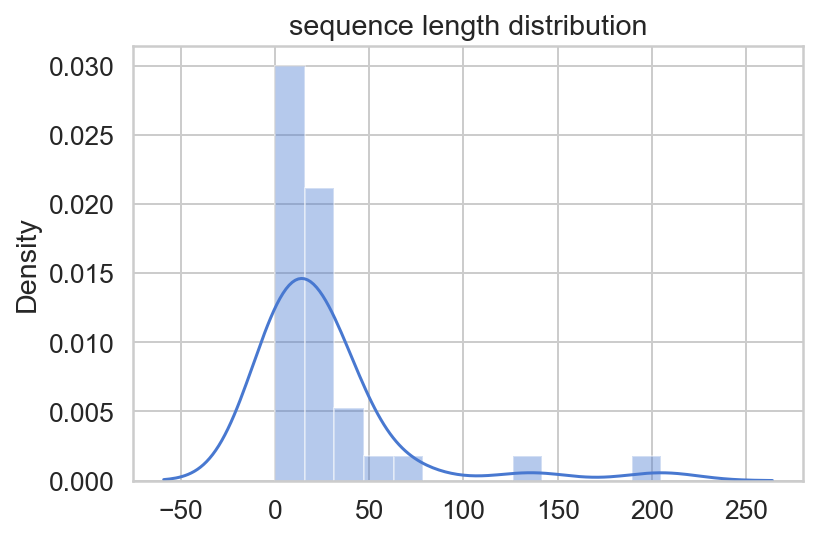

In [18]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
ax = sns.distplot(amino_parkin['count'].values)
plt.title(f'sequence length distribution')
plt.grid(True) 
#mostly data covered with in the range of 40